<a href="https://colab.research.google.com/github/maragraziani/intro-interpretableAI/blob/main/L4A2_TCAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4: Assignment 2
## Concept Attribution with TCAV (Testing with Concept Activation Vectors) [1]

**Created by:**
- Mara Graziani
    - PhD student at Hes-so Valais & University of Geneva
    - mara.graziani@hevs.ch  

This notebook contains the instructions and commands given in  gihub.com/tensorflow/tcav to run TCAV examples. I am mostly running their commands in a configuration that leads to a working result. If you follow their instructions carefully, you will be able to change model and input data. 

**Note that running this notebook requires quite some time to download the data and the models.**    

#### Content
* [Introduction](#intro)
* [Installation & Data](#Section0)
* Let's get started
* Writing a model Wrapper
* Access internal Activations
* Run TCAV
* Exercises 1, 2, 3


#### Take-away messages

* TCAV shows the importance of high level concepts (e.g., color, gender, race) for a prediction class - this is much closer to how humans communicate than showing the importance of raw input pixels (such as in CAM, Grad-CAM, saliency).
* TCAV learns concepts from examples. For instance, TCAV needs a couple of examples of female, and something not female to learn a "gender" concept. 
* You don't need to change or retrain your network to use TCAV.


Credits: 

Great part of the content in this notebook were taken and adapted from https://github.com/tensorflow/tcav/blob/master/Run_TCAV.ipynb 
of Copyright 2018 Google LLC, Licensed under the Apache License, Version 2.0 (the "License");

If you want to expand your experiments further you are strongly encouraged to visit the main repo: https://github.com/tensorflow/tcav/

[1]
Been Kim, Martin Wattenberg, Justin Gilmer, Carrie Cai, James Wexler, Fernanda Viegas, Rory Sayres. Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV), ICML 2018 https://arxiv.org/abs/1711.11279

# Introduction 

Testing with Concept Activation Vectors (TCAV) is a new interpretability method to understand what signals your neural networks models uses for prediction. TCAV shows the importance of high-level concepts, such as "striped texture" or "blue color" or "dotted texture" or "female sex" for a prediction class. 

There are three main steps for running TCAV:

1. Collect N random datasets, where it is recommended that N
is at least 10.
2. Fix the concept dataset = dataset representative of a concept that you would want to investigate. Calculate the TCAV score using each of the N random datasets
3. Apply a two-sided t-test to verify if your score for the selected dataset of interest (the concept dataset) is significantly higher than the random ones. 

How do you compute the TCAV score? 

1. Find the CAV 
2. Evaluate the sensitivity of the output with respect to the CAV over a dataset 
3. Ensamble the sensitivity scores obtained in two by a final measure or relevance 


We will perform this step by step. 

# Installation and Data

Let us clone the github repo, create the datasets and load the tcav library. Note: This may take a while. 


In [1]:
!git clone https://github.com/tensorflow/tcav.git

Cloning into 'tcav'...
remote: Enumerating objects: 679, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 679 (delta 14), reused 14 (delta 3), pack-reused 632
Receiving objects: 100% (679/679), 626.20 KiB | 2.51 MiB/s, done.
Resolving deltas: 100% (406/406), done.


In [2]:
!pip install tcav

     |████████████████████████████████| 61kB 4.8MB/s 


In [3]:
#tcav/tcav_examples/image_models/imagenet
%mkdir /content/data
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=/content/data --number_of_images_per_folder=10 --number_of_random_folders=10

/content/tcav/tcav/tcav_examples/image_models/imagenet
INFO:tensorflow:Fetching imagenet data for zebra
INFO:tensorflow:Saving images at /content/data/zebra
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.featurepics.com/FI/Marked/20060909/Zebra84929.jpg
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 403: Forbidden for URL http://bonfire.learnnc.org/zoo/week02/photos/mccrary_zootales/images/zebra.jpg
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.istockphoto.com/file_thumbview_approve/269671/2/istockphoto_269671_zebra.jpg
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 410: Gone for URL http://www.mediastorehouse.com/image/Grevys-Zebra_463879.jpg
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.lorilamont.com/Zebra.jpg
INFO:tensorflow:Problem

In [14]:
!bash /content/tcav/tcav/tcav_examples/image_models/imagenet/FetchDataAndModels.sh

Streaming output truncated to the last 5000 lines.
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00017498_color.png  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00011228_object.png  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00015713_color.png  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00002804_color.png  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00000069_color.png  
  inflating: broden1_224/broden1_224/images/ade20k/ADE_train_00013146_color.png  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_train_00018148_color.png  
  inflating: broden1_224/broden1_224/images/ade20k/ADE_train_00016001_object.png  
  inflating: broden1_224/broden1_224/images/ade20k/ADE_train_00002640.jpg  
 extracting: broden1_224/broden1_224/images/ade20k/ADE_val_00000811_object.png  
  inflating: broden1_224/broden1_224/images/ade20k/ADE_train_00019344_object.png  
  inflating: broden1_224/broden1_224/images/ade20k/

# Let us get started: 
1. Loading tensorflow and tcav, deactivating TF2 beavior: TCAV was developed mostly for TF1, so the full transition to v.2. is still difficult. 
2. Storing concepts and target class images


**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.
You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).
You can change this path to where your data and models are located.

**cav_dir**: directory to store CAVs

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.

In [5]:
%load_ext autoreload
%autoreload 2
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [20]:
# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live. 
source_dir = '/content/data' # you can change this path to where your data are
bottlenecks = [ 'mixed4c']  # @param 
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]

# Writing a model wrapper

Next step, we define a subclass of the ModelWrapper abstract class in tensorflow. This wrapper includes several functions that will be needed to compute TCAV, for example get_prediction. 

We create the wrapper with the fuction model.GoogleNetWrapper_public.

In [16]:
# COPY the model weights to the default tcav folder
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/inception5h/' '/content/tcav/tcav/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/inception5h/' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'


In [17]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

# Here we create the Wrapper
mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


The model wrapper will let us access the model predictions. The next step is accessing the internal activations. 
# Access internal activations

This is done in TCAV by an interface called ActivationGenerationInterface. 

In [23]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)


# Run TCAV

So far, we are still in point 1. of the list above with the steps to compute TCAV, namely we are still on:
1. find the CAV. 

To find the CAV, we needed a) images b) model c) access to the model predictions and d) access to the model activations.  

The function below wraps together all the next steps, namely it will 
1. find the CAV by solving a linear classification task
2. compute concept sensitivity scores per each input image
3. evaluate the TCAV score

You can set the verbosity to 1 to see all the steps.


In [24]:
tf.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

This may take a while... Go get coffee!
done!


Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.51 (+- 0.24), random was 0.51 (+- 0.28). p-val = 0.981 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.83 (+- 0.19), random was 0.51 (+- 0.28). p-val = 0.001 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.80 (+- 0.17), random was 0.51 (+- 0.28). p-val = 0.002 (significant)
{'mixed4c': {'bn_vals': [0.01, 0.8300000000000001, 0.8], 'bn_stds': [0, 0.19000000000000003, 0.17320508075688776], 'significant': [False, True, True]}}


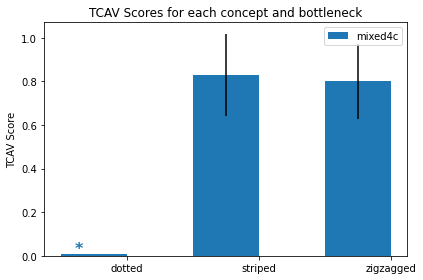

In [25]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

# Exercises
1. Change the model to mobile net. Build anoter wrapper, and rerun the evaluation. What else do you need to change to make this work (hint: maybe the bottleneck layer will need a different name?) How do the TCAV scores change? 
2. Switch the verbosity when running TCAV to 1. Can you recognize the different steps? 
3. (Optional) Try TCAV on your model and images! 